# <b> <font color='red'> <center> Air Quality </center> </font> </b>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2024-09-27 16:37:15.522608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 16:37:15.522939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 16:37:15.662007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 16:37:15.960150: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 16:37:18.057469: W tensorflow/compiler/tf2

DATASET


Vito, S. (2008). Air Quality [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C59K5F.


https://archive.ics.uci.edu/dataset/360/air+quality

In [2]:
!ls data

air+quality


In [3]:
! ls data/air+quality

AirQualityUCI.csv  AirQualityUCI.xlsx


When datasets are published, their documentation often describes how missing or invalid data is represented. In the case of the Air Quality dataset from the UCI Machine Learning Repository, the creators have mentioned that missing data points are represented by the value -200 in certain columns.

### Dataset info

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2)  and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.
This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded.

In [4]:
# Load the dataset
df = pd.read_csv('data/air+quality/AirQualityUCI.csv', sep=';', decimal=',', parse_dates=[['Date', 'Time']], na_values=-200)

# Drop the unnamed columns and rows with NaN values
df_clean = df.drop(columns=['Unnamed: 15', 'Unnamed: 16']).dropna()

# Set the Date_Time as the index
df_clean = df_clean.set_index('Date_Time')

# Select the relevant features and the target variable
df_filtered = df_clean[['T', 'CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'RH', 'AH']]


In [5]:
df_filtered.head()

,T,CO(GT),NMHC(GT),C6H6(GT),RH,AH
Date_Time,,,,,,
10/03/2004 18.00.00,13.6,2.6,150.0,11.9,48.9,0.7578
10/03/2004 19.00.00,13.3,2.0,112.0,9.4,47.7,0.7255
10/03/2004 20.00.00,11.9,2.2,88.0,9.0,54.0,0.7502
10/03/2004 21.00.00,11.0,2.2,80.0,9.2,60.0,0.7867
10/03/2004 22.00.00,11.2,1.6,51.0,6.5,59.6,0.7888


We want to predict temperature given the other values.

We have:

N: number of rows
T: time steps
D = 5: number of features



In [6]:
# Convert dataframe to NumPy array for TensorFlow compatibility
data = df_filtered.values

In [7]:
# Modify the windowed dataset creation to separate the target (temperature) from the features
def windowed_dataset(data, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    
    # Create sliding windows of size window_size + 1 (for the label)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the dataset and create feature/label pairs
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Features are all columns except the last temperature column at time t+1
    # Target is the temperature at time t+1 (index 0 because temperature is the first column in filtered data)
    dataset = dataset.map(lambda window: (window[:-1, 1:], window[-1][0]))  # Only take 'T' as target
                # before it was just window[-1] but I only want to predict temperature
                # similar for the features
    
    # Shuffle, batch, and prefetch
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


In [8]:
# Parameters
window_size = 7  # Use the past 7 time steps as features; T
batch_size = 1
shuffle_buffer_size = 1000

In [9]:
# Create the dataset
dataset = windowed_dataset(data, window_size, batch_size, shuffle_buffer_size)

In [10]:
for x,y in dataset.take(1):
    print(x.shape) # batch size, time steps, features
    print(y.shape)

(1, 7, 5)
(1,)


In [11]:
for x,y in dataset.take(1):
    print(x)
    print()
    print(y)

tf.Tensor(
[[[  1.8    151.       9.1     42.2      0.8679]
  [  1.4    112.       6.1     51.8      0.8433]
  [  1.9    117.       7.5     76.4      0.9953]
  [  1.2    120.       5.9     47.7      0.8819]
  [  2.3    251.      12.7     37.1      0.7598]
  [  3.3    435.      13.5     48.7      0.8089]
  [  3.1    345.      14.5     71.3      0.9514]]], shape=(1, 7, 5), dtype=float64)

tf.Tensor([10.], shape=(1,), dtype=float64)


En 7 pasos de tiempo, con 5 características, puedo predecir un valor de temperatura.

In [12]:
# now lets use a bigger batch size

In [13]:
# Assuming you have 5 features (excluding temperature)
num_features = data.shape[1] - 1  # Subtract 1 for temperature



model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(window_size, num_features)),  # input_shape should match your features
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)  # Output layer should predict a single temperature value
])




# Compile the model
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

# Train the model
history = model.fit(dataset, epochs=8)


Epoch 1/8
820/820 [==============================] - 1s 1ms/step - loss: 60.4976
Epoch 2/8
820/820 [==============================] - 1s 1ms/step - loss: 32.9559
Epoch 3/8
820/820 [==============================] - 1s 1ms/step - loss: 31.2105
Epoch 4/8
820/820 [==============================] - 1s 1ms/step - loss: 29.8468
Epoch 5/8
820/820 [==============================] - 1s 1ms/step - loss: 27.2931
Epoch 6/8
820/820 [==============================] - 1s 1ms/step - loss: 25.6790
Epoch 7/8
820/820 [==============================] - 1s 1ms/step - loss: 25.1346
Epoch 8/8
820/820 [==============================] - 1s 1ms/step - loss: 23.6864


If you pass a batch of input data with shape (batch_size, window_size, num_features) (where num_features is 5), the predictions will have the shape (batch_size, 1).

In [14]:
# Suppose you want to predict using the last 7 time steps from your dataset
# Here `input_data` must have the shape (batch_size, 7, 5) for the model to accept it

# Example: Taking the last batch of data for predictions
last_batch = data[-(window_size + 1):]  # Get the last (window_size + 1) rows
input_data = last_batch[:-1, 1:].reshape(1, window_size, 5)  # Shape (1, 7, 5)


print(input_data.shape)


# Make predictions
predictions = model.predict(input_data)

# Check the shape and values of predictions
print(predictions.shape)  # Should print (1, 1)
print(predictions)        # This will show the predicted temperature value

(1, 7, 5)
1/1 [==============================] - 0s 90ms/step
(1, 1)
[[18.699203]]


In [15]:
# Use the model to predict the temperature for the next time step
predictions = model.predict(dataset.take(1))  # Example: predicting on the first batch
print(predictions.shape)

print(predictions)

1/1 [==============================] - 0s 119ms/step
(1, 1)
[[11.565009]]


In [16]:
for x, y in dataset.take(1):
    print(x)
    print()
    print(y)
    sal = model.predict(x)
    print()
    print(sal)

tf.Tensor(
[[[  1.7     98.       6.9     70.1      0.9503]
  [  1.7    102.       6.4     69.8      0.939 ]
  [  0.8     69.       3.3     70.3      0.9092]
  [  1.      89.       4.      73.4      0.9129]
  [  1.4    134.       6.      70.5      0.9142]
  [  1.7    157.       8.2     71.       0.9279]
  [  2.     167.       9.9     64.       0.9206]]], shape=(1, 7, 5), dtype=float64)

tf.Tensor([15.], shape=(1,), dtype=float64)
1/1 [==============================] - 0s 69ms/step

[[16.09794]]


In [23]:
data.shape

(827, 6)

In [17]:
import seaborn as sns

In [29]:
data[0]

array([ 13.6   ,   2.6   , 150.    ,  11.9   ,  48.9   ,   0.7578])

In [45]:
df_filtered['Date_Time']

KeyError: 'Date_Time'

In [48]:
time = df_filtered.index.values
time

array(['10/03/2004 18.00.00', '10/03/2004 19.00.00',
       '10/03/2004 20.00.00', '10/03/2004 21.00.00',
       '10/03/2004 22.00.00', '10/03/2004 23.00.00',
       '11/03/2004 00.00.00', '11/03/2004 01.00.00',
       '11/03/2004 02.00.00', '11/03/2004 05.00.00',
       '11/03/2004 06.00.00', '11/03/2004 07.00.00',
       '11/03/2004 08.00.00', '11/03/2004 09.00.00',
       '11/03/2004 10.00.00', '11/03/2004 11.00.00',
       '11/03/2004 12.00.00', '11/03/2004 13.00.00',
       '11/03/2004 14.00.00', '11/03/2004 15.00.00',
       '11/03/2004 16.00.00', '11/03/2004 17.00.00',
       '11/03/2004 18.00.00', '11/03/2004 19.00.00',
       '11/03/2004 20.00.00', '11/03/2004 21.00.00',
       '11/03/2004 22.00.00', '11/03/2004 23.00.00',
       '12/03/2004 00.00.00', '12/03/2004 01.00.00',
       '12/03/2004 02.00.00', '12/03/2004 05.00.00',
       '12/03/2004 06.00.00', '12/03/2004 07.00.00',
       '12/03/2004 08.00.00', '12/03/2004 10.00.00',
       '12/03/2004 11.00.00', '12/03/2004 12.0

In [50]:
time.shape, data[:,0].shape

((827,), (827,))

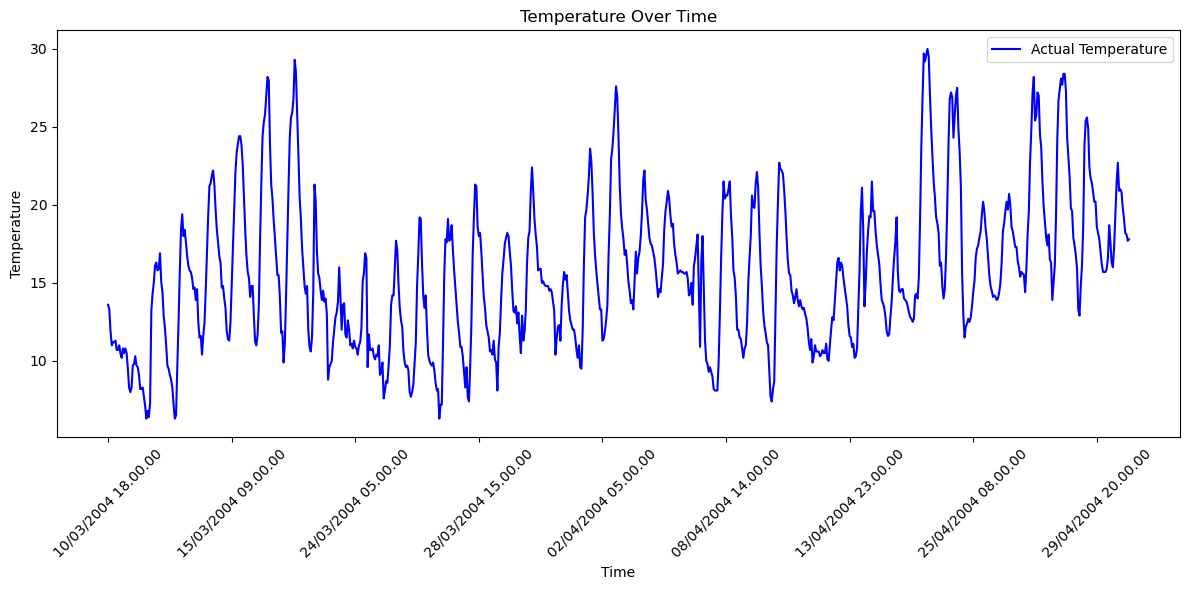

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data is a NumPy array where:
# - data[:, 0] contains timestamps (converted to a suitable format if needed)
# - data[:, 5] contains temperature

# Sample data
# time = np.arange(0, 100, 1)  # Example timestamp array for demonstration
# temperature = np.random.uniform(low=15, high=30, size=100)  # Example temperature data
# data = np.column_stack((time, temperature))  # Combine for example purposes

time = time  # Timestamps
temperature = data[:, 0]  # Temperature values

plt.figure(figsize=(12, 6))
plt.plot(time, temperature, label='Actual Temperature', color='blue')

# Set the title and labels
plt.title('Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()

# Set custom ticks on the x-axis
# Choose the indices or specific timestamps you want to mark
tick_indices = np.arange(0, len(time), 100)  # Example: every 100th index
plt.xticks(ticks=time[tick_indices], rotation=45)  # Rotate for better visibility

plt.tight_layout()  # Adjust layout to make room for tick labels
plt.show()


In [31]:
data.shape

(827, 6)

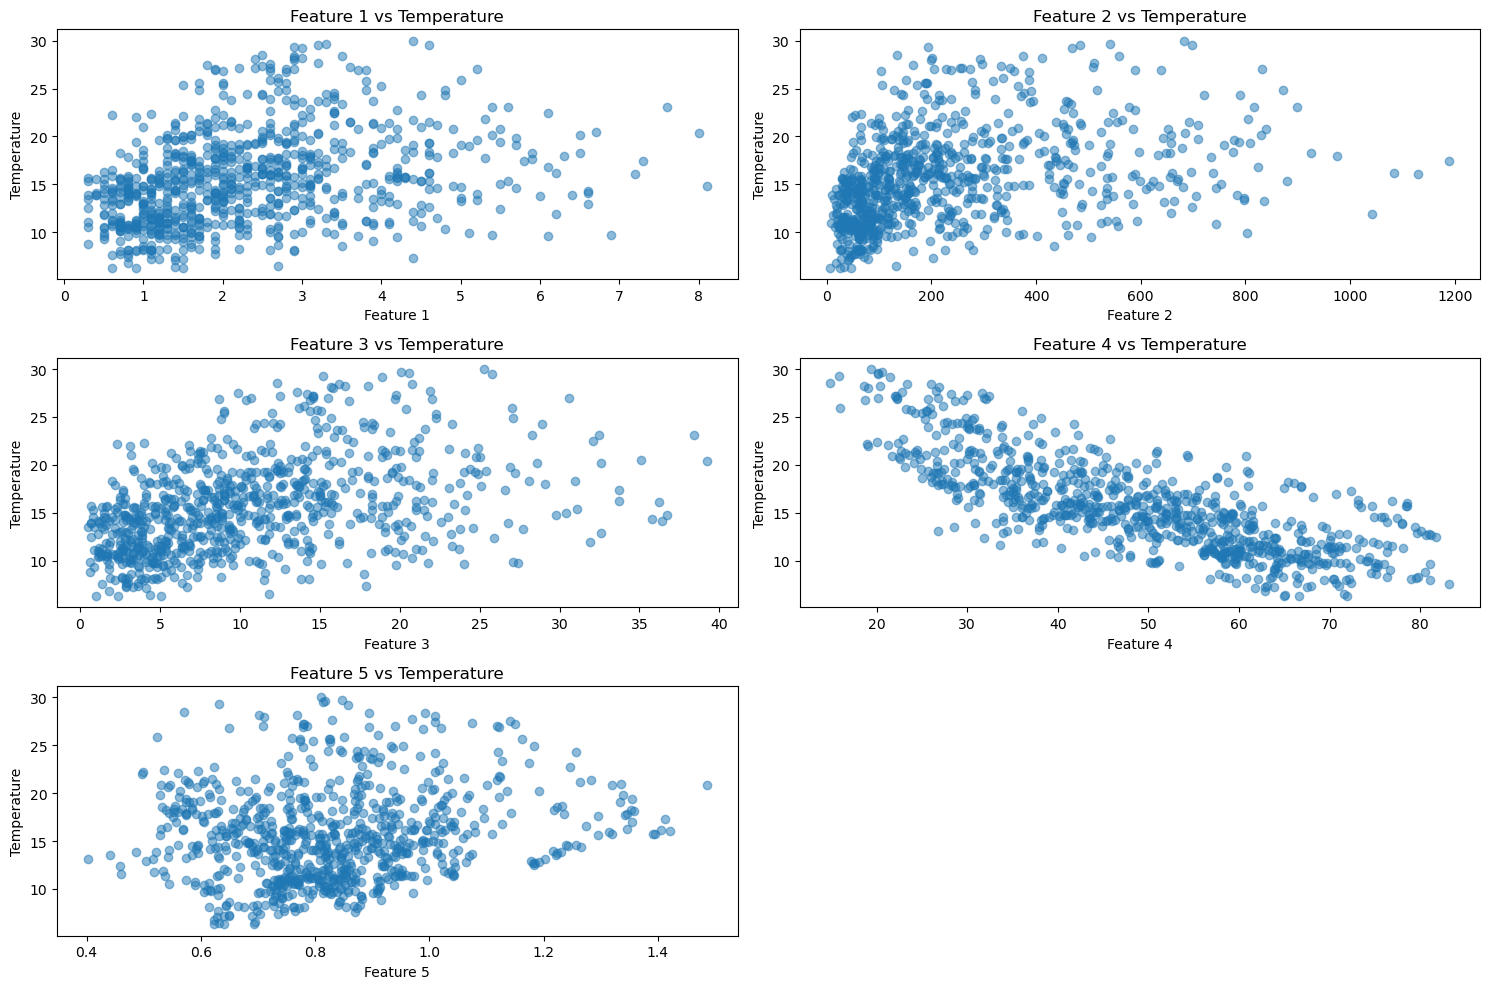

In [36]:

# plot features vs target

# Assuming data shape is (num_samples, 6) where the first column is temperature
temperature = data[:, 0]

# Create scatter plots for each feature against temperature
plt.figure(figsize=(15, 10))

for i in range(1, data.shape[1]):  # Start from 1 to skip the temperature column
    plt.subplot(3, 2, i)  # Adjust the layout based on the number of features
    plt.scatter(data[:, i], temperature, alpha=0.5)
    plt.title(f'Feature {i} vs Temperature')
    plt.xlabel(f'Feature {i}')
    plt.ylabel('Temperature')

plt.tight_layout()
plt.show()


In [33]:
data[0]

array([ 13.6   ,   2.6   , 150.    ,  11.9   ,  48.9   ,   0.7578])

data[:, 0] refers to the first column of the array.

data[:, 1] refers to the second column.

data[:, 2] refers to the third column.

data[:, 3] refers to the fourth column.

data[:, 4] refers to the fifth column.

data[:, 5] refers to the sixth column (which is your target variable in this case).

In [54]:
# Calculate the correlation matrix
correlation_matrix = df_filtered.corr()

# Print the entire correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                 T    CO(GT)  NMHC(GT)  C6H6(GT)        RH        AH
T         1.000000  0.318261  0.366976  0.418409 -0.769869  0.159964
CO(GT)    0.318261  1.000000  0.887167  0.972660 -0.105157  0.295591
NMHC(GT)  0.366976  0.887167  1.000000  0.897928 -0.160257  0.282142
C6H6(GT)  0.418409  0.972660  0.897928  1.000000 -0.178410  0.313415
RH       -0.769869 -0.105157 -0.160257 -0.178410  1.000000  0.475776
AH        0.159964  0.295591  0.282142  0.313415  0.475776  1.000000
